In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

Using TensorFlow backend.


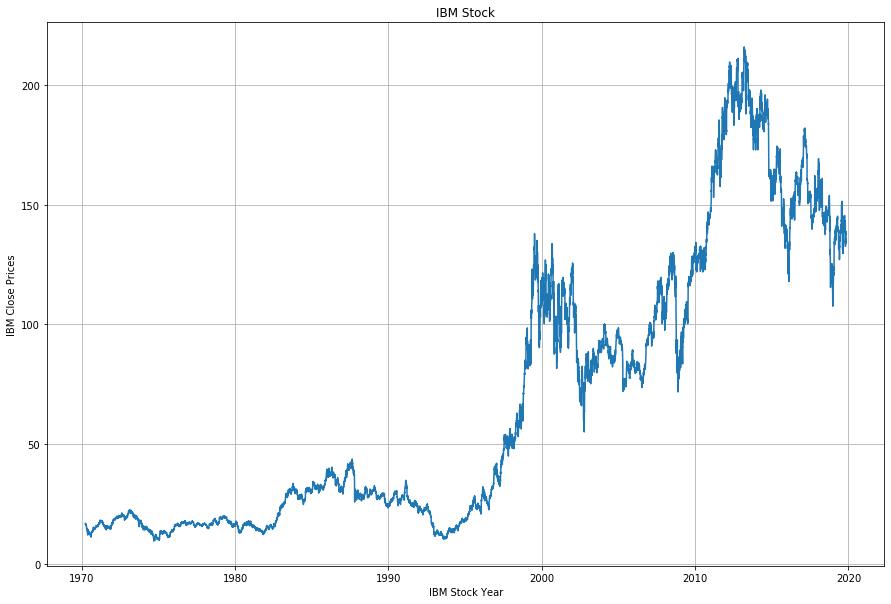

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('/Users/saurabhwadhawane/stockdata1_IBM.csv', sep=',', parse_dates=['date'], index_col='date',date_parser=dateparse)

plt.figure(figsize=(15,10))
plt.grid(True)
plt.title("IBM Stock")
plt.xlabel('IBM Stock Year')
plt.ylabel('IBM Close Prices')
plt.savefig('IBM_1.pdf')
plt.plot(data['close']);                   

In [3]:
data.shape

(12520, 7)

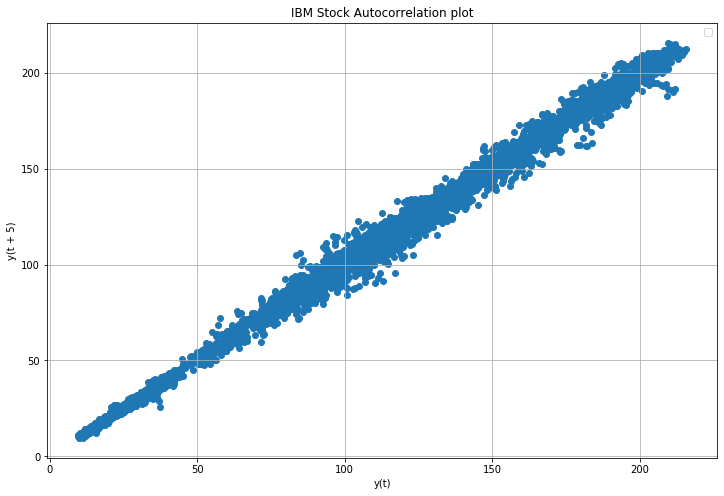

In [4]:
#Autocorrelation plot
plt.figure(figsize=(12,8))
lag_plot(data['close'], lag=5)
plt.title('IBM Stock Autocorrelation plot')
plt.grid(True)
plt.legend();

<Figure size 1152x576 with 0 Axes>

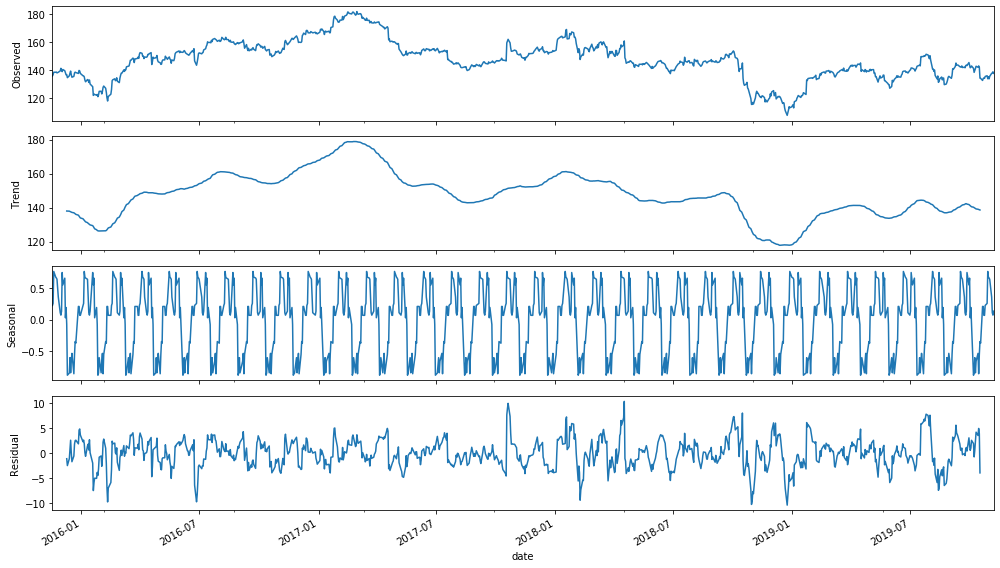

In [5]:
rcParams['figure.figsize'] = 14, 8
data_arima = data['close']
result = seasonal_decompose(data_arima[-1000:], model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

In [6]:
values = DataFrame(data['close'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)


             t       t+1       t+5      t+10      t+30
t     1.000000  0.998995  0.997849  0.993317  0.999739
t+1   0.998995  1.000000  0.998748  0.994065  0.998748
t+5   0.997849  0.998748  1.000000  0.995143  0.997623
t+10  0.993317  0.994065  0.995143  1.000000  0.993133
t+30  0.999739  0.998748  0.997623  0.993133  1.000000


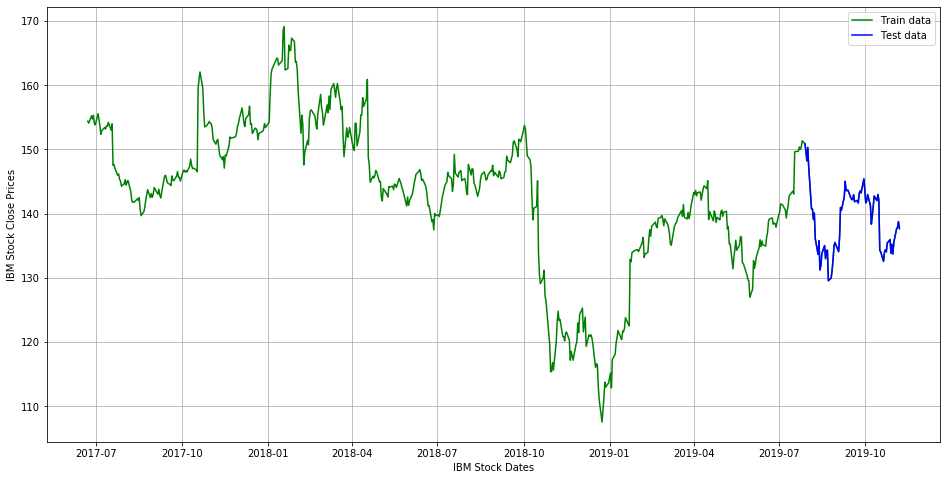

In [7]:
train_data, test_data = data[0:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('IBM Stock Dates')
plt.ylabel('IBM Stock Close Prices')
plt.plot(data['close'].tail(600), 'green', label='Train data')
plt.plot(test_data['close'], 'blue', label='Test data')
plt.legend()

In [23]:
#Autoregression Model

train_ar = train_data['close']
test_ar = test_data['close']

model = AR(train_ar)# train autoregression
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
 


/Users/saurabhwadhawane/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Lag: 40
MSE: 4.417058064780802
MAE: 1.5698535928274504
RMSE: 2.101679819758662


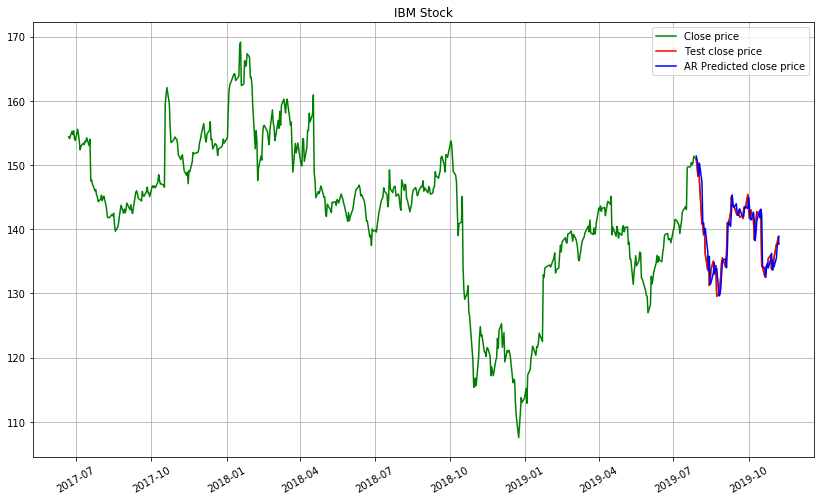

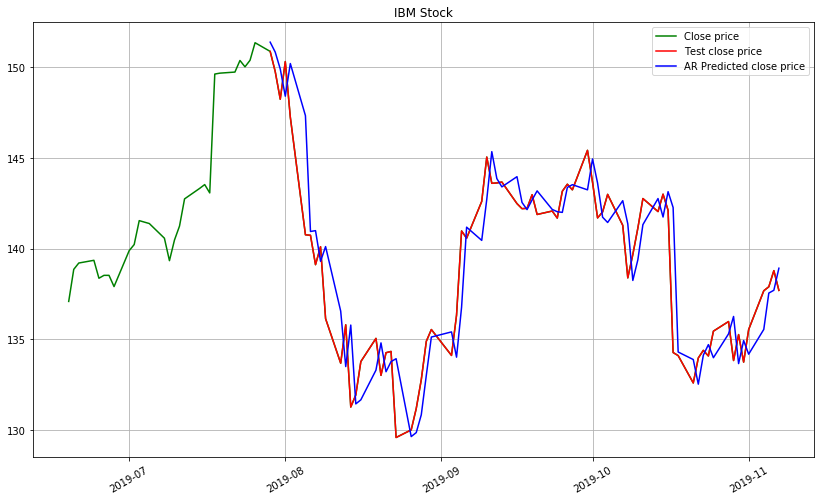

In [24]:
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['close'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='AR Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.title("IBM Stock")
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['close'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='AR Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.title("IBM Stock")
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['close'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['close'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['close'], predictions))))

In [28]:
train_arma = train_data['close']
test_arma = test_data['close']

history = [x for x in train_arma]
y = test_arma
# make first prediction
predictions = list()
model = ARMA(history, order=(1,10))
model_fit = model.fit(disp=1)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARMA(history, order=(1,10))
    model_fit = model.fit(disp=1)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)


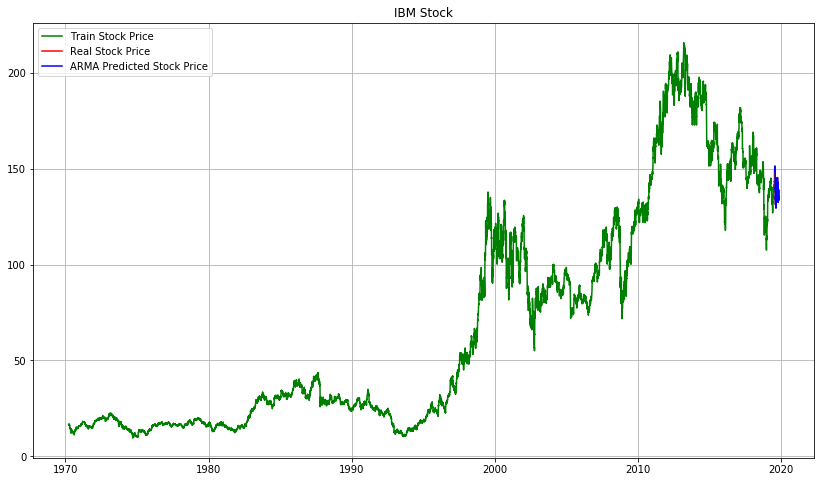

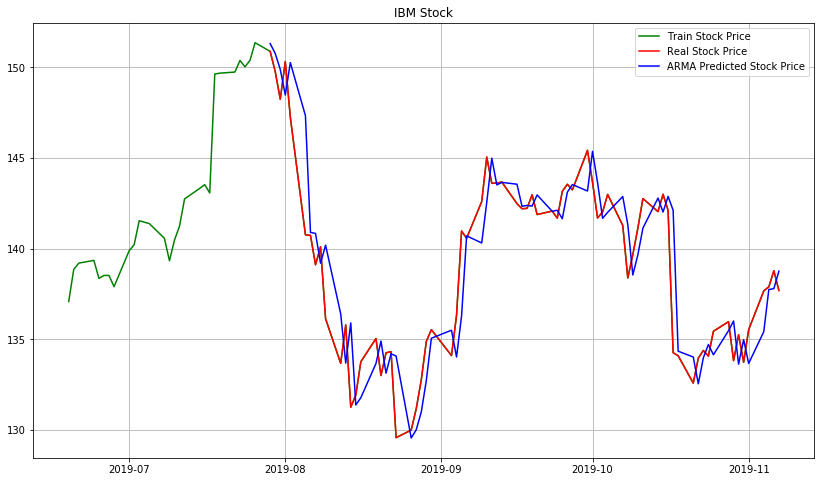

MSE: 4.421316222794121
MAE: 1.5436839408108645
RMSE: 2.102692612531399


In [29]:
plt.figure(figsize=(14,8))
plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'ARMA Predicted Stock Price')
plt.legend()
plt.title("IBM Stock")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['close'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'ARMA Predicted Stock Price')
plt.legend()
plt.title("IBM Stock")
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [8]:
train_arima = train_data['close']
test_arima = test_data['close']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    


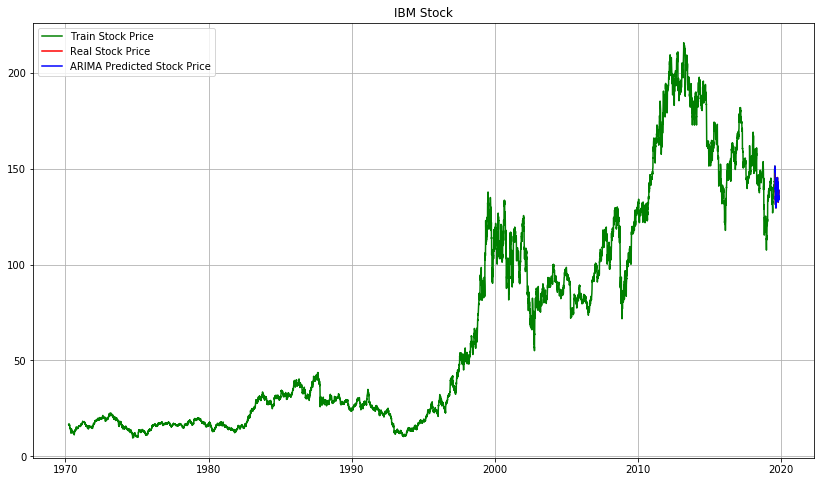

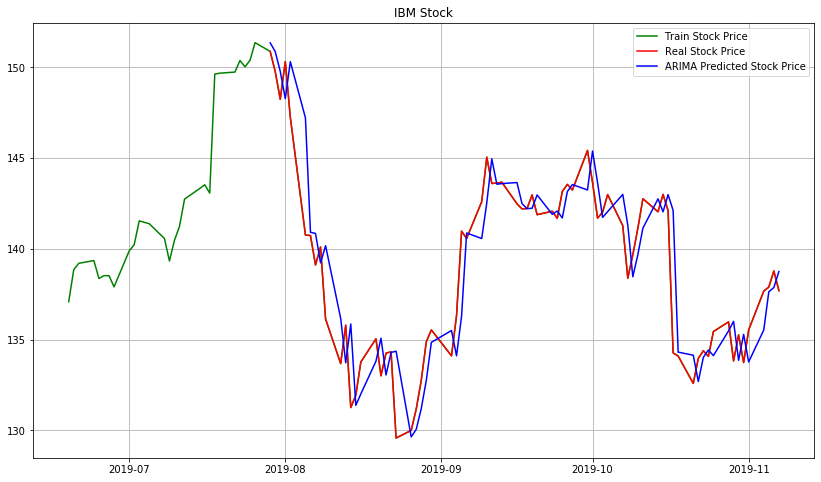

MSE: 4.381295979333128
MAE: 1.536350963022093
RMSE: 2.0931545521850814


In [9]:
plt.figure(figsize=(14,8))
plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'ARIMA Predicted Stock Price')
plt.legend()
plt.title("IBM Stock")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['close'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'ARIMA Predicted Stock Price')
plt.legend()
plt.title("IBM Stock")
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [20]:
#Facebook_Prophet
# Drop the columns
ph_df_train = train_data.drop(['open', 'high', 'low','adjclose','volume','ticker'], axis=1)
ph_df_train['date'] = ph_df_train.index
ph_df_train.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

prop = Prophet(changepoint_prior_scale=0.1)
prop.fit(ph_df_train)
# Create Future dates
future_prices = prop.make_future_dataframe(periods=73)

# Predict Prices
forecast = prop.predict(future_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


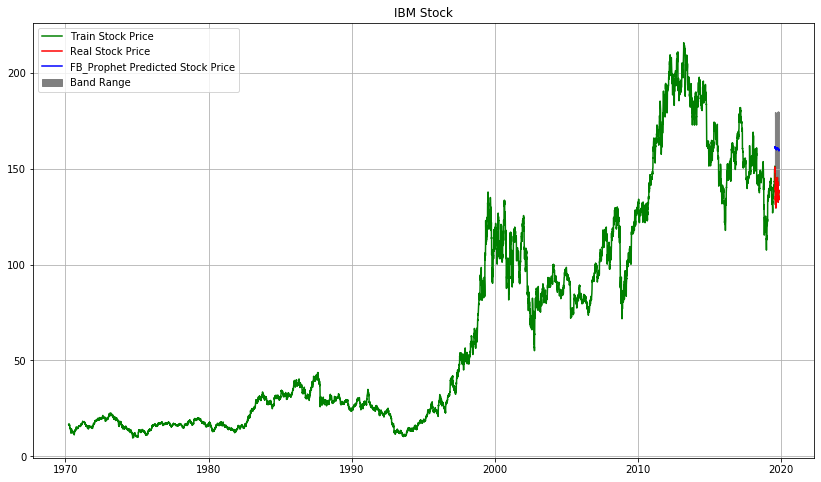

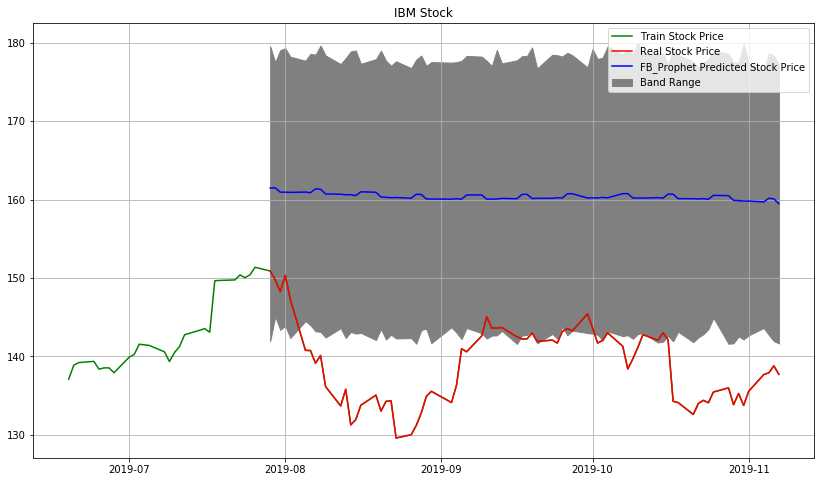

MSE: 481.29527929913536
MAE: 21.385266776295577
RMSE: 21.93844295521301


In [21]:
plt.figure(figsize=(14,8))
plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['close'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'FB_Prophet Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.title("IBM Stock")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['close'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['close'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'FB_Prophet Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.title("IBM Stock")
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(test_data['close'], forecast['yhat'][-73:])))
print('MAE: '+str(mean_absolute_error(test_data['close'], forecast['yhat'][-73:])))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['close'], forecast['yhat'][-73:]))))

In [34]:
#LSTM
train = train_data.iloc[:, 0:1].values # selecting close prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [35]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 300, batch_size = 16)

Epoch 1/300
12440/12440 [==============================] - 7s 553us/step - loss: 0.0040
Epoch 2/300
12440/12440 [==============================] - 6s 462us/step - loss: 0.0013
Epoch 3/300
12440/12440 [==============================] - 6s 480us/step - loss: 0.0010
Epoch 4/300
12440/12440 [==============================] - 6s 481us/step - loss: 9.6721e-04
Epoch 5/300
12440/12440 [==============================] - 6s 474us/step - loss: 9.2360e-04
Epoch 6/300
12440/12440 [==============================] - 6s 480us/step - loss: 8.1705e-04
Epoch 7/300
12440/12440 [==============================] - 6s 478us/step - loss: 8.7748e-04
Epoch 8/300
12440/12440 [==============================] - 6s 479us/step - loss: 8.1190e-04
Epoch 9/300
12440/12440 [==============================] - 6s 480us/step - loss: 8.2235e-04
Epoch 10/300
12440/12440 [==============================] - 6s 485us/step - loss: 8.0066e-04
Epoch 11/300
12440/12440 [==============================] - 6s 482us/step - loss: 8.2114e-0

12440/12440 [==============================] - 6s 457us/step - loss: 6.4509e-04
Epoch 177/300
12440/12440 [==============================] - 6s 449us/step - loss: 6.3218e-04
Epoch 178/300
12440/12440 [==============================] - 6s 449us/step - loss: 6.8356e-04
Epoch 179/300
12440/12440 [==============================] - 6s 447us/step - loss: 6.6195e-04
Epoch 180/300
12440/12440 [==============================] - 6s 482us/step - loss: 6.3114e-04
Epoch 181/300
12440/12440 [==============================] - 6s 458us/step - loss: 6.5005e-04
Epoch 182/300
12440/12440 [==============================] - 6s 459us/step - loss: 6.5038e-04
Epoch 183/300
12440/12440 [==============================] - 6s 484us/step - loss: 6.7360e-04
Epoch 184/300
12440/12440 [==============================] - 6s 460us/step - loss: 6.1989e-04
Epoch 185/300
12440/12440 [==============================] - 6s 468us/step - loss: 6.4706e-04
Epoch 186/300
12440/12440 [==============================] - 7s 549us/step

In [36]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking close price
# combine original train and test data vertically
# as previous close Prices are not present in test dataset
# e.g. for predicting close price for first date in test data, we will need stock close prices on timesteps previous dates  
combine = pd.concat((train_data['close'], test_data['close']), axis = 0)
# our test inputs also contains stock close Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

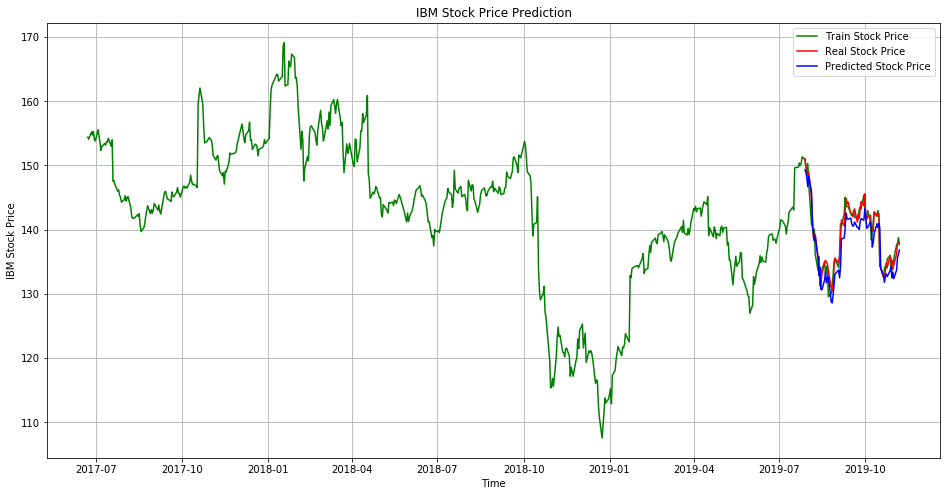

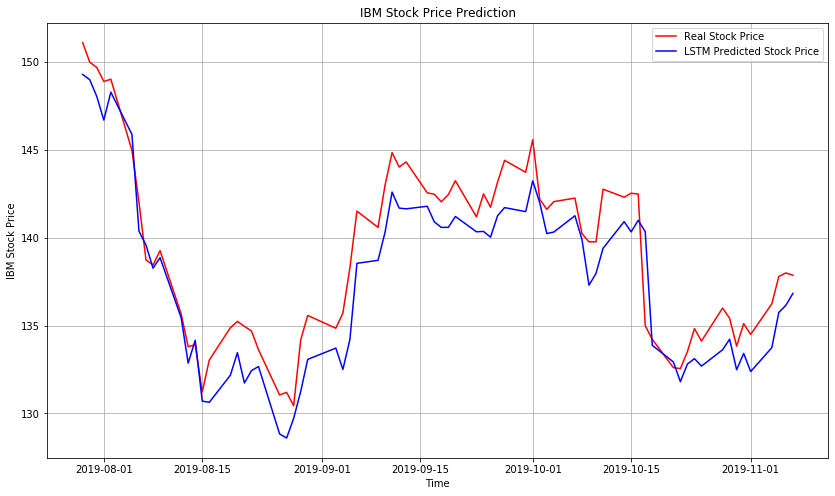

MSE: 3.9375339508224703
MAE: 1.7328750401327642
RMSE: 1.984322038083151


In [41]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_IBM_NOV.pdf')
plt.show()

#plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'LSTM Predicted Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_IBM_NOV.pdf')
plt.show()



mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))